### *The OLG-model with an Increasing Population and Non-Zero Probability of Premature Death*

We explore the link between the OLG model's population dynamics by extending the model to include the impact of the pandemic on population growth rates and expected survival probabilities.Effectively this means that the probability of surviving is just an additional discount rate.A higher expected survival probability implies that individuals expect to live longer and potentially benefit from their savings in the future. In response, households may choose to save more in order to maintain a higher level of consumption in their old age. Similarly, a lower expected survival probability may lead to lower savings and higher current consumption.


In [101]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
from modelproject import OLGModelClass
from scipy import optimize
from modelproject import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



**(i) The household's maximisation problem**
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\mathbb{E}[p_{t}]\cdot\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,0 < p < 1, \beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}N_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}N_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    


where:

 $C_1t$ is the consumption at period t

 $C_{2t+1}$ is the consumption at period t+1
  
 $w_{t}$ is the wage

 $r_{t+1}$ is the interest rate
  
 $\mathbb{E}[p_{t}]$ is the expected survival probability
  
 $\beta$ is the discount factor , 0<$\beta$ < 1 


**(ii) The production function**   
$$
\begin{aligned}
Y_{t}=F(K_{t-1},L_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)L_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    

Profits:    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}L_{t}-r_{t}^{K}K_{t-1}
\end{aligned}




**(iii) Population:**
Labour force:
$$
\begin{aligned}
Pop^{young}_{t+1}=L_{t+1} = (1 + n)  L_t
\end{aligned}
$$
Old generation:
$$
\begin{aligned}
Pop^{old}_{t+1}=p_{t}\cdot Pop^{young}_{t}
\end{aligned}
$$

**(iv) Capital:**
$$
\begin{aligned}
K_{t+1} = (1+\delta)K_t+I_t
\end{aligned}
$$

# Population Growth

The survival probability has been intially set to 95% for all periods (with population size increasing by 2% in each period) to imply times before the pandemic hit.

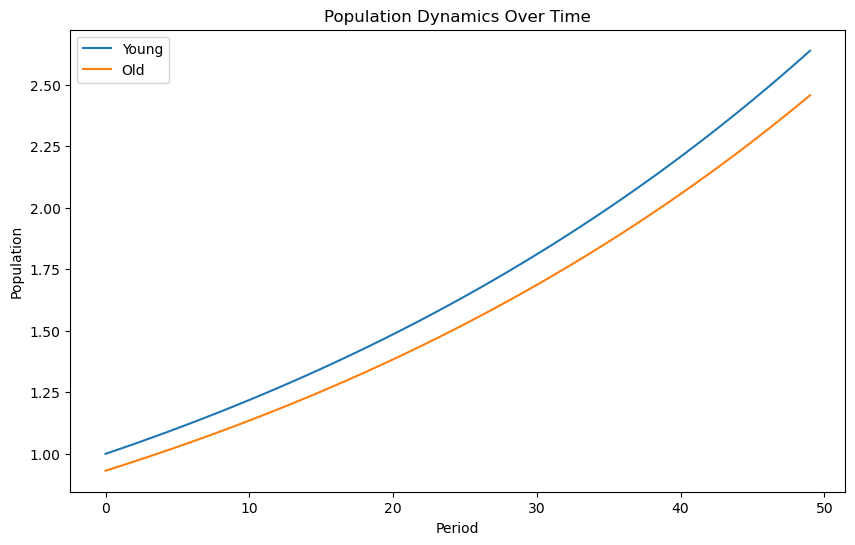

In [102]:
# a. create and simulate the model
model = OLGModelClass(do_print=False)
par = model.par
sim = model.sim

p = 0.95 # survival probability
par.n = 0.02 # population growth
par.p = np.full(par.simT, p) 
par.exp_p = np.concatenate(([0.95], par.p)) # static expected survival probability in period t which is equal to that of period t-1 

model.simulate(do_print=False)


# b. plot the populations over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.par.pop_young, label="Young")
plt.plot(range(model.par.simT), model.par.pop_old, label="Old")
plt.xlabel("Period")
plt.ylabel("Population")
plt.legend()
plt.title("Population Dynamics Over Time")
plt.show()

# Capital

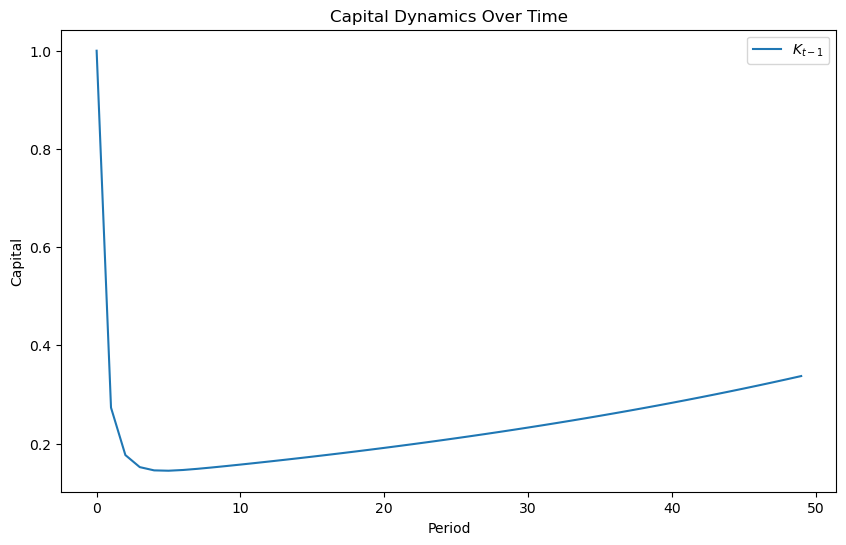

In [103]:
# a. plot the lagged capital over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag, label=r"$K_{t-1}$")
plt.xlabel("Period")
plt.ylabel("Capital")
plt.legend()
plt.title("Capital Dynamics Over Time")
plt.show()


# Capital Share of Income

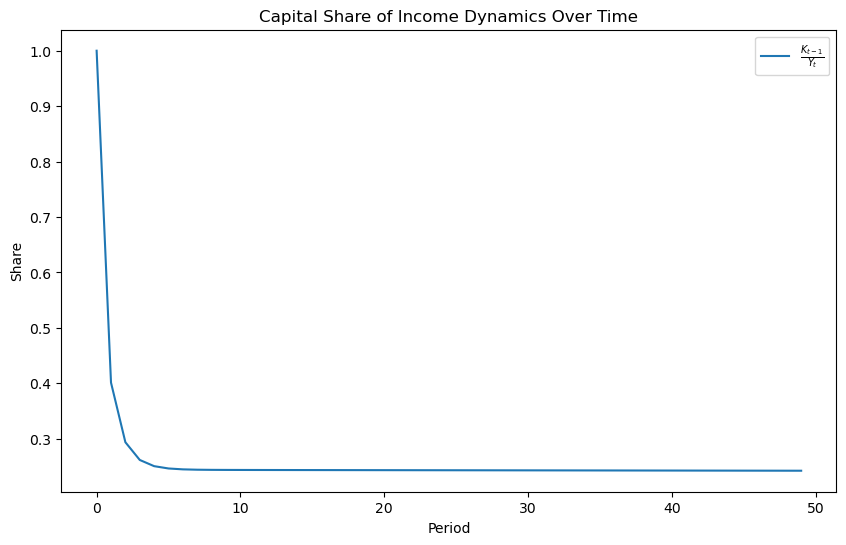

In [104]:
# a. plot the lagged capital share of income over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()

<font color='red'> You need to describe the algorithm used for the solution - just showing the solution and simulation is not sufficient. This is particularly the case, when your code is so heavily based on lecture code. Remember, you only get points for work you have done yourselves, so at the very minimum you need to show how you use the lecture code to analyze your specific problem.

You should probably also comment a bit on what you are simulating. What are the mechanisms behind the convergence process? What are the differences between your model and the lecture model?

Finally, in the standard OLG model, capital is owned by the old generation. Since in your model, 5 pct. of the elderly die prematurely, you need to take a stance on what happens to the capital, they own. They way you write it above, it is redistributed among the remaining old generation (because they receive interest on last periods savings). 

In the standard OLG model, the capital stock is typically transferred from one generation to the next. However, in our extension where a portion of the elderly dies prematurely, we assume that it is redistributed among the remaining old generation (because they receive interest on last periods savings) which indirectly affects their capital accumulation.

# Comparative Statistics
In this section, we modify some parameters of the OLG  to compare  the effects of increased risk aversion and decreased patience in the OLG model and the model extension.
The CRRA (Constant Relative Risk Aversion) coefficient, is decreased by 0.25 implying higher risk aversion and the discount factor is modified by increasing the denominator by 0.1 to represent slightly lower level of patience. 

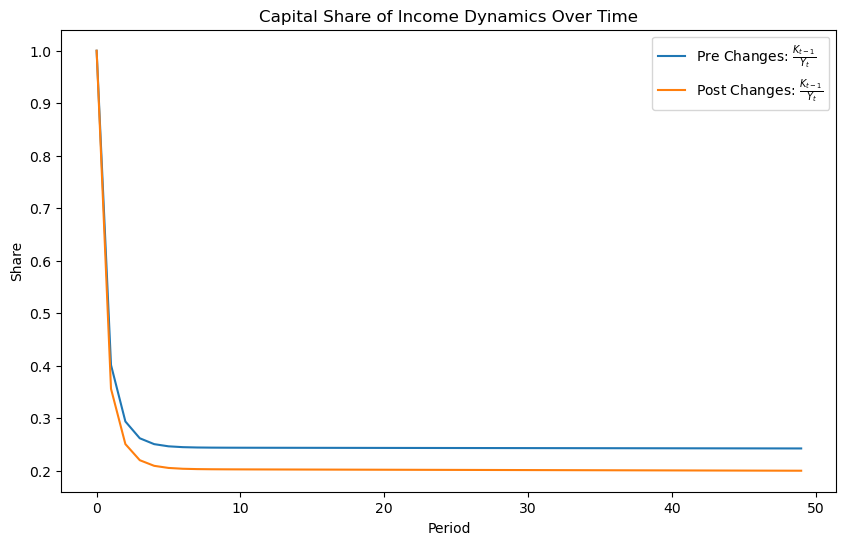

In [105]:
# a. parameter changes

# i. households
par.sigma = 1.75 # CRRA coefficient - decreased by 0.25
par.beta = 1/1.50 # discount factor - increased denominator by 0.1
# 
# ii. firms
par.alpha = 0.40 # capital weight - increased by 0.1
par.theta = 0.8  # substitution parameter - increased by 0.05
par.delta = 0.30 # depreciation rat - decreased by 0.2

# # # b. firms

par.alpha = 0.30 # capital weight
par.theta = 0.05 # substitution parameter
par.delta = 0.50 # depreciation rate

# iii. government
par.tau_w = 0.20 # labor income tax - increased by 0.1
par.tau_r = 0.10 # capital income tax - decreased by 0.1

# b. plot the lagged capital share of income pre and post the parameter changes
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"Pre Changes: $\frac{K_{t-1}}{Y_t}$")
model.simulate(do_print=False)
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"Post Changes: $\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()


<font color='red'> Please describe what you are analyzing here, and what the point of this simulation is.

An advantage of simulating models is that we can change one parameter at a time, simulate and by comparing to the base, we can isolate the effect of the parameter we change - it is a true ceteris paribus scenario, because we have explicitely held all other factors fixed. Above, you are changing 7 parameters, and the difference between the two simulations reflect the effects of all 7 parameters. We cannot disentagle the effects from each other, and therefore it is very difficult to say, what is actually happening. 

# Pandemic

In [107]:
# a. create and simulate the model
model = OLGModelClass(do_print=False)
par = model.par
sim = model.sim 

p = 0.95 # survival probability
par.n = 0.02 # population growth
par.p = np.full(par.simT, p) 
par.p[10:20] = 0.6 # temporary pandemic decreases the survival probability
par.exp_p = par.exp_p = np.concatenate(([0.95], par.p)) # static expected survival probability in period t+1 which is equal to that of period t 

model.simulate(do_print=False)

# b. plot the populations over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.par.pop_young, label="Young")
plt.plot(range(model.par.simT), model.par.pop_old, label="Old")
plt.xlabel("Period")
plt.ylabel("Population")
plt.legend()
plt.title("Population Dynamics Over Time with Pandemic")
plt.show()


AttributeError: 'types.SimpleNamespace' object has no attribute 'simT'

The plot provides a visual representation of how the temporary decrease in survival probability during the pandemic impacts the population dynamics of the young and old generations in the OLG model.From periods 10 to 20, the survival probability is adjusted to 0.6, representing a decrease in survival rates during the pandemic .Consequently, the population of the old generation is lower than it would have been without the temporary decrease in the survival probability (indicated by the dip in the population levels in the graph).


# Capital

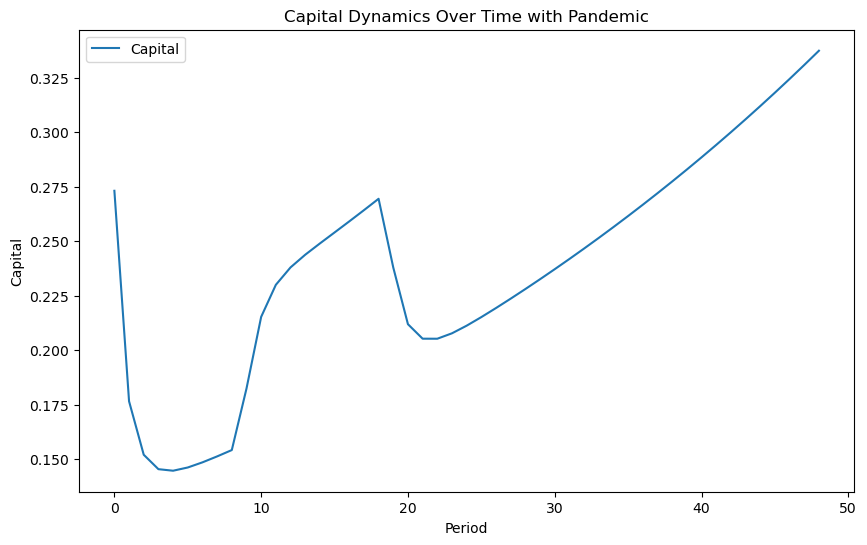

In [ ]:
# a. plot the lagged capital over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K, label="Capital")
plt.xlabel("Period")
plt.ylabel("Capital")
plt.legend()
plt.title("Capital Dynamics Over Time with Pandemic")
plt.show()


<font color='red'> Note how the effect on capital takes place the period before the population drop. In the solution, you include p[t+1] in the euler equation, this means that agents know beforehand that the probability of death is going to increase and incorporate that in their savings decisions. Is that realistic? 

I was wondering why capital seems to increase - wouldn't we expect a fall in savings if the young people know that they will probablly die in the next period? Turns out that the way you wrote the capital tansition in your code, capital drops by (1-p)K between each period - so capital owned by those that die seems to vanish into thin air. This gives rise to some weird capital dynamics... I've marked the points in your code, where that assumption shows up.

As expected,the temporary decrease in the survival probability during the pandemic period has implications for the capital dynamics in the OLG model.A decrease in the survival probability affects the population dynamics by reducing the number of individuals who survive to the next period. As a result, there is a lower number of individuals saving and investing.This leads to a lower level of capital accumulation over the pandemic period.

# Capital Share of Income

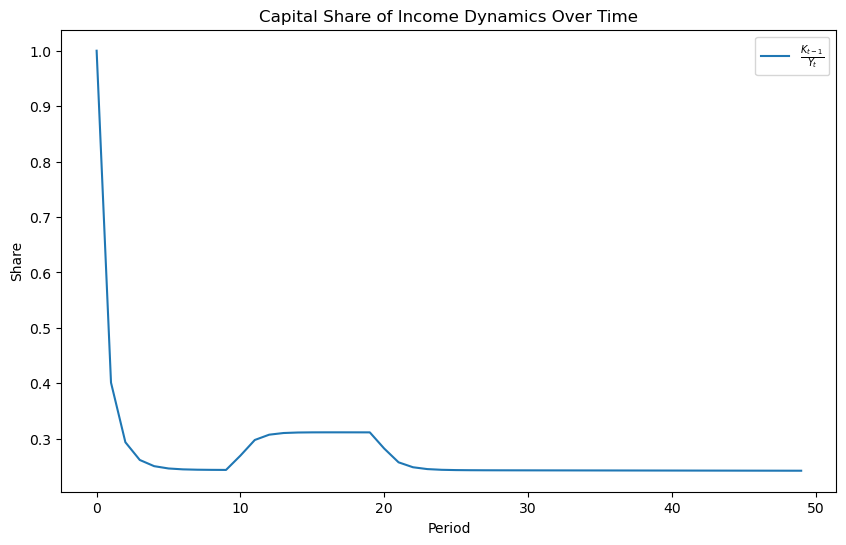

In [ ]:
# a. plot the lagged capital share of income over time
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"$\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()

# Comparative Statistics

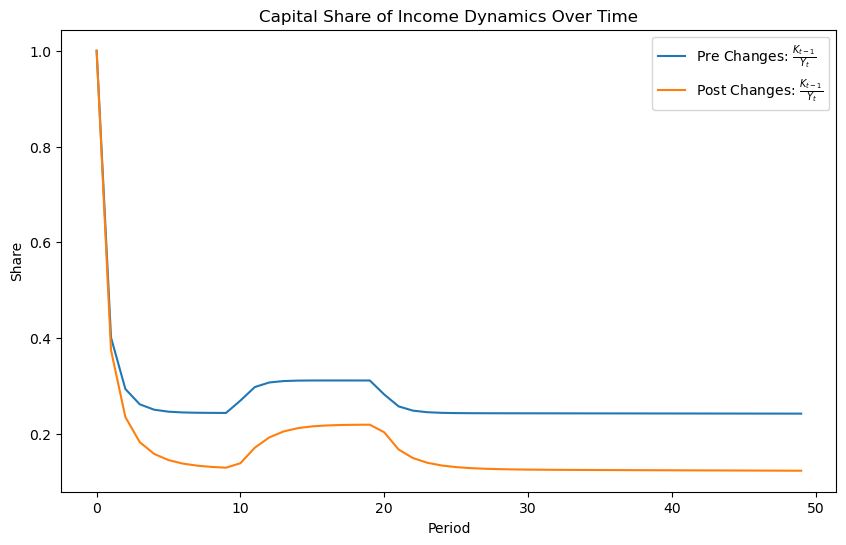

In [ ]:
# a. parameter changes

# i. households
par.sigma = 1.75 # CRRA coefficient - decreased by 0.25
par.beta = 1/1.50 # discount factor - increased denominator by 0.1

# ii. firms
par.alpha = 0.40 # capital weight - increased by 0.1
par.theta = 0.1 # substitution parameter - increased by 0.05
par.delta = 0.30 # depreciation rat - decreased by 0.2

# iii. government
par.tau_w = 0.20 # labor income tax - increased by 0.1
par.tau_r = 0.10 # capital income tax - decreased by 0.1

# b. plot the lagged capital share of income pre and post the parameter changes
plt.figure(figsize=(10, 6))
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"Pre Changes: $\frac{K_{t-1}}{Y_t}$")
model.simulate(do_print=False)
plt.plot(range(model.par.simT), model.sim.K_lag/model.sim.Y, label=r"Post Changes: $\frac{K_{t-1}}{Y_t}$")
plt.xlabel("Period")
plt.ylabel("Share")
plt.legend()
plt.title("Capital Share of Income Dynamics Over Time")
plt.show()


In [ ]:
class OLGModel:
    def __init__(self, crra_coefficient, discount_factor):
        self.crra_coefficient = crra_coefficient
        self.discount_factor = discount_factor

    def simulate(self):
        # Simulation logic goes here
        pass

    def analyze_results(self):
        # Analysis of simulation results goes here
        pass

# Create an instance of the OLGModel with modified parameters
modified_model = OLGModel(crra_coefficient=1.5, discount_factor=0.9)

# Run the simulation with modified parameters
modified_model.simulate()

# Analyze and interpret the results
modified_model.analyze_results()


<font color='red'> same comment as before - one parameter change at a time, or we'll have no idea what we are actually looking at.